In [1]:
# Import/download necessary libraries.
!pip install contractions

import re, string, unicodedata
import contractions
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

# Downlaod stopwords lists.
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Read in the Dataset**

In [2]:
# Mount a drive on Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Read in the dataset.
data = pd.read_csv('drive/My Drive/Tweets.csv')

In [4]:
# Inspect the dataset.
data.shape

(14640, 15)

In [5]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


**Drop Unnecessary Columns**

In [6]:
# Drop all columns from the dataset except for 'text' and 'airline_sentiment'
data = data[['text', 'airline_sentiment']]

In [7]:
# Inspect shape and first five rows of new working dataset.
data.shape

(14640, 2)

In [8]:
data.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


**Preprocess Dataset**

In [9]:
# Define functions for Data Pre-processing.

# HTML tag removal.
def remove_html_tags(text):
    # Accept a string argument. Remove HTML tags from the string.
    bs = BeautifulSoup(text, "html.parser")
    return bs.get_text()

# Remove contractions.
def remove_contractions(text):
    # Accept a string argument. Remove contractions from this string.
    text_no_contractions = contractions.fix(text)
    return text_no_contractions

# Remove Numbers.
def remove_numbers(text):
    # Accept a string argument. Apply a regex to the string to remove numeric characters.
    text = re.sub(r'\d+', '', text)
    return text

# Remove punctuation.
def remove_punctuation(list_words):
    # Accept a list of words. Apply a regex to each word to remove punctuation.
    words = []
    for word in list_words:
        corrected_word = re.sub(r'[^\w\s]', '', word)
        if corrected_word:
            words.append(corrected_word)

    return words

# Remove Special Characters and Punctuation.
def remove_special_characters(list_words):
    # Accept a list of words. Remove special characters from each word.
    words = []
    for word in list_words:
        corrected_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        words.append(corrected_word)

    return words

# Remove Stopwords
def remove_stopwords(list_words):
    # Accept a list of words. Remove words from list that are stopwords.
    words = []
    for word in list_words:
        if word not in stopwords:
            words.append(word)

    return words

# Convert words to lowercase.
def lowercase_words(list_words):
    # Accept a list of words, lowercase each word.
    lowercased_words = []
    for word in list_words:
        lowercased_word = word.lower()
        lowercased_words.append(lowercased_word)

    return lowercased_words

# Lemmatize words.
def lemmatize_words(list_words):
    # Accept a list of words, lemmatize each word in the list.
    lemmatized_words = []
    for word in list_words:
        lemmatized_word = wnl.lemmatize(word, pos='v')
        lemmatized_words.append(lemmatized_word)

    return lemmatized_words

# Tokenization.
def tokenize(text):
    # Accept one string variable, parse the string into a list of words.
    return nltk.word_tokenize(text)

def preprocess_text(text):
    # Process text as one string per each record.
    text = remove_html_tags(text)
    text = remove_numbers(text)
    text = remove_contractions(text)
    # Process text as a list of strings - Tokenized format.
    text = tokenize(text)
    text = remove_punctuation(text)
    text = remove_special_characters(text)
    text = remove_stopwords(text)
    text = lowercase_words(text)
    text = lemmatize_words(text)
    # Join the list of tokenized words back into one string.
    text = ' '.join(text)

    # Return the text as one string after pre-processing has been applied.    
    return text

In [10]:
# Retrieve list of stopwords to be removed in pre-processing.
stopwords = stopwords.words('english')

# Initialize a Lemmatizer for pre-processing.
from nltk.stem.wordnet import WordNetLemmatizer
wnl = WordNetLemmatizer()

# Apply text preprocessing function to each record in the dataset.
data['text'] = data.apply(lambda record: preprocess_text(record['text']), axis=1)

In [11]:
# Inspect data after pre-processing.
data.head()

,text,airline_sentiment
0,virginamerica what dhepburn say,neutral
1,virginamerica plus add commercials experience ...,positive
2,virginamerica i today must mean i need take an...,neutral
3,virginamerica really aggressive blast obnoxiou...,negative
4,virginamerica really big bad thing,negative


**Vectorization**

In [12]:
# Define functions for vectorization.

def get_data_features(dataset, vectorizer):
    # Use a vectorizer object and fit on the dataset.
    data_features = vectorizer.fit_transform(data['text'])
    return data_features.toarray()

def format_labels(dataset):
    # Format the labels in the dataset from strings to integers.
    labels = dataset["airline_sentiment"]
    labels = labels.replace({"negative": 0, "neutral": 1, "positive": 2})
    labels = labels.astype('int')

    return labels

**CountVectorizer**

In [13]:
# CountVectorizer.

from sklearn.feature_extraction.text import CountVectorizer
cv_vectorizer = CountVectorizer(max_features=1000)

cv_data_features = get_data_features(data, cv_vectorizer)
cv_labels = format_labels(data)

In [14]:
# Split dataset into training and test sets for CountVectorization.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(cv_data_features, cv_labels, test_size=.2, random_state=1)

In [15]:
# Train the model.
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

cv_rfc = RandomForestClassifier(n_estimators = 10, n_jobs=4) 
cv_rfc = cv_rfc.fit(X_train, y_train)

In [16]:
# Make prediction.
cv_prediction = cv_rfc.predict(X_test)

**Evauluate CountVectorizer Model**

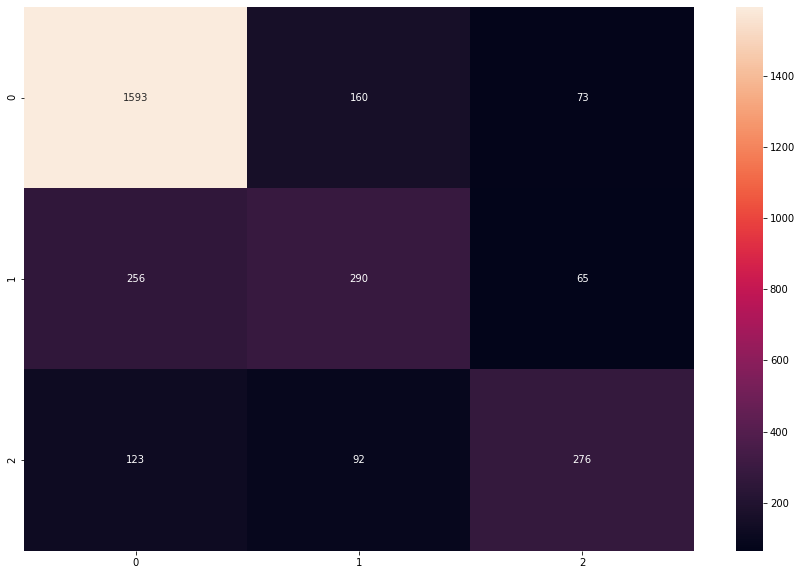

In [17]:
# Display Confusion Matrix.
from sklearn.metrics import confusion_matrix

cv_cm = confusion_matrix(y_test, cv_prediction)

plt.figure(figsize=(15,10))
sns.heatmap(cv_cm, annot=True, fmt='g')

In [18]:
# Evaluate metrics.

from sklearn import metrics

metrics.accuracy_score(y_test, cv_prediction)

0.737363387978142

**TF-IDF Vectorizer**

In [19]:
# TfidfVectorizer.

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

tfidf_data_features = get_data_features(data, tfidf_vectorizer)
tfidf_labels = format_labels(data)

In [20]:
# Split dataset into training and test sets for TfidfVectorization.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tfidf_data_features, tfidf_labels, test_size=.2, random_state=1)

In [21]:
# Train the model.
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

tfidf_rfc = RandomForestClassifier(n_estimators = 10) 
tfidf_rfc = tfidf_rfc.fit(X_train, y_train)

In [22]:
# Make prediction.
tfidf_prediction = tfidf_rfc.predict(X_test)

**Evaluate TfidfVectorizer**

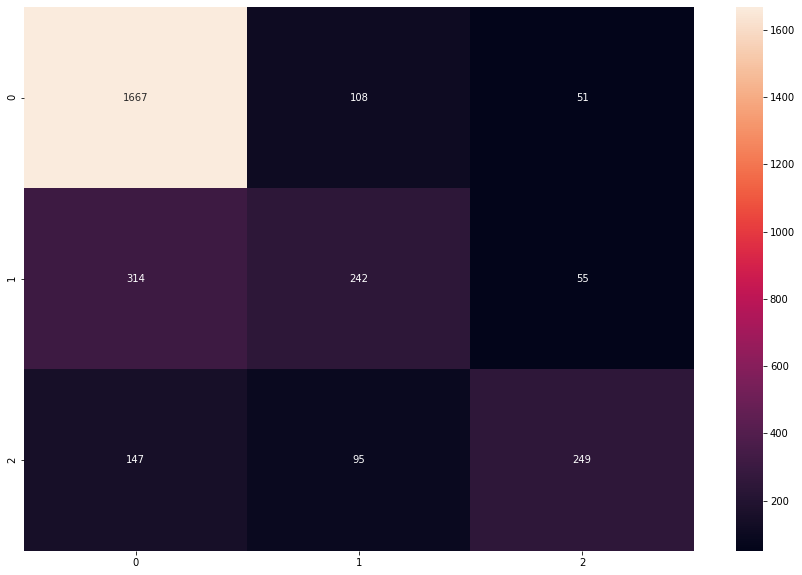

In [23]:
# Display Confusion Matrix.
from sklearn.metrics import confusion_matrix

tfidf_cm = confusion_matrix(y_test, tfidf_prediction)

plt.figure(figsize=(15,10))
sns.heatmap(tfidf_cm, annot=True, fmt='g')

In [24]:
# Evaluate metrics.

from sklearn import metrics

metrics.accuracy_score(y_test, tfidf_prediction)

0.7370218579234973

**Conclusion / Summary**

- The dataset consisted of tweets about an airline that contained a feature indicating whether the sentiment of the tweet was positive, negative, or neutral.
- A model was built to learn from this set of tweets to try to determine sentiment based on text in the tweets.
- The data were pre-processed by dropping irrelevant features. Next, a series of functions were applied to the data to remove HTML tags, punctuation, numerical characters, words with contractions, special characters, and stopwords. Finally, all the words were lowercased.
- The dataset was vecotrized using two kinds of vectorization (Count Vectorization and TF-IDF Vectorization). The vectorization converts the series of words into numbers, allowing us to input them into a Random Forest Classifier model.
- The Count Vectorizer generally represents how frequently a word occurs, while the TF-IDF Vectorizer provides a weight for words that are more important to the context of the text.
- The data were fit  on the model using both vectorizer types, and after training the models, predictions were made on test sets.
- The model that used the TF-IDF achieved slightly better accuracy than the model that used the Count Vectorizer, although the difference is negligible.
- Based on the Confusion Matrix generated for each model, both models appear to be better at classifying text with negative sentiment. Both models appear to struggle classifying neutral sentiment in text, which intuitively makes sense, as neutrality is somewhat ambiguous and subjective.
- The dataset appears to have signifcantly more text with negative sentiment which could impact how the model performed.